In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import pstats
import sys
import io
import pandas as pd

In [2]:
planDict = {}
with open("benchmark_plan.txt", "r") as file:
    for line in file.readlines():
        vals = line.split("=")
        if len(vals) != 2 and "\n" not in vals:
            raise Exception("Error in line:\n" + line + "\nPlease include only one = per line.")
        if "\n" not in vals:
            planDict[vals[0]] = vals[1][:len(vals[1])-1]

In [3]:
planDict

{'nGens': '3',
 'offspring': '100,500',
 'cpuTrials': '1,5,10,20,35,50,65,80',
 'N': '1',
 'clean': 'Fals'}

Text(0.5, 0, 'Number of CPUS')

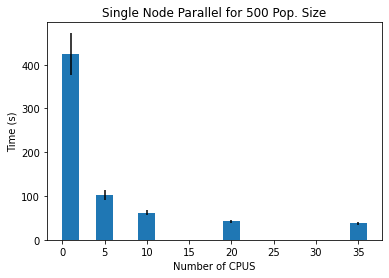

In [4]:
res = {}
cpus = np.array([int(elem) for elem in planDict['cpuTrials'].split(",")])
cpus = cpus[cpus < 44]
offspring = [int(elem) for elem in planDict['offspring'].split(",")] 

def readLog(cpu, offspring, nodes=1):
    runtimes = []
    with open("runTimeLogs/{}C{}N_{}O.log".format(cpu,nodes, offspring) \
              , "r") as file:
        for line in file.readlines():
            if "nCpus" in line:
                nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
                assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
            if "took:" in line:
                runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
                #print(runtime)
                runtimes.append(runtime)
    return runtimes


for cpu in cpus:
    res[cpu] = readLog(cpu=cpu,offspring=500)
resMean = [np.mean(res[key]) for key in res.keys()]
resStd = [np.std(res[key]) for key in res.keys()]

plt.bar(list(res.keys()), resMean, yerr=resStd,width=2)
plt.title("Single Node Parallel for 500 Pop. Size")
plt.ylabel("Time (s)")
plt.xlabel("Number of CPUS")

In [5]:
res2 = {}
for cpu in cpus:
    res2[cpu] = readLog(cpu=cpu,offspring=1000)
resMean2 = np.array([np.mean(res2[key]) for key in res2.keys()])
resStd2 = np.array([np.std(res2[key]) for key in res2.keys()])

plt.plot(list(res.keys()), resMean, color="green")
plt.scatter(list(res.keys()), resMean, marker="o", color="green", label="500 pop size")
plt.fill_between(list(res2.keys()), resMean2-resStd2, resMean2+resStd2, alpha=0.5)
plt.plot(list(res2.keys()), resMean2, color="blue")
plt.scatter(list(res2.keys()), resMean2, marker="o", color="blue", label="1000 pop size")

print()
plt.plot(list(res.keys()), resMean, color="green")
plt.scatter(list(res.keys()), resMean, marker="o", color="green", label="ideal")
plt.ylabel("Time (s)")
plt.xlabel("Number of CPUS")
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/1C1N_1000O.log'

In [ ]:
allExps = []
for cpu in cpus:
    resDict = {}
    for pop in offspring[:4]:
        resDict[pop] = readLog(cpu=cpu,offspring=pop)
    allExps.append(resDict)
    
def plotDict(res, label="1 cpu", color="blue", marker="o"):
    resMean = np.array([np.mean(res[key]) for key in res.keys()])
    resStd = np.array([np.std(res[key]) for key in res.keys()])
    plt.fill_between(list(res.keys()), resMean-resStd, resMean+resStd, alpha=0.2, color=color)
    plt.plot(list(res.keys()), resMean, color=color)
    plt.scatter(list(res.keys()), resMean, marker="o", color=color, label=label)
    
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


plt.figure(figsize=(10,8))
cmap = [get_cmap(len(allExps))(i) for i in range(len(allExps))]
labels = [str(cpu) + " cpus" for cpu in cpus]
[plotDict(exp, label=label, color=color) for exp,color,label in zip(allExps, cmap, labels)]
    
plt.ylabel("Time (s)")
plt.ylim(0,400)
plt.xlabel("Pop Size")
plt.legend()
plt.savefig("3plots.png",bbox_inches = 'tight')


In [ ]:
numPlots = len(list(allExps[0].keys()))
fig, axs = plt.subplots(nrows=numPlots, ncols=1, figsize=(7,15))
plt.subplots_adjust(bottom=.2, top=2)
pops =  list(allExps[0].keys())
for i in range(numPlots):
    curr_pop = pops[i]
    curr_cpu_mean_time = {}
    curr_cpu_std_time = {}
    for exp,cpu in zip(allExps,cpus):
        curr_cpu_mean_time[cpu] = np.mean(exp[curr_pop])
        curr_cpu_std_time[cpu] = np.std(exp[curr_pop])
    meanList = np.array(list(curr_cpu_mean_time.values()))
    stdList = np.array(list(curr_cpu_std_time.values()))
    maxTime = np.mean(allExps[0][curr_pop])
    idealTime = [maxTime / cpu for cpu in cpus]
    axs[i].scatter(curr_cpu_mean_time.keys(),curr_cpu_mean_time.values(), marker="o", color="blue")
    axs[i].plot(list(curr_cpu_mean_time.keys()),\
                list(curr_cpu_mean_time.values()), color="blue", label="actual runtime")
    axs[i].scatter(curr_cpu_mean_time.keys(),idealTime, marker="*", color="red")
    axs[i].plot(list(curr_cpu_mean_time.keys()),\
                idealTime, color="red", label="ideal runtime")
    axs[i].set_ylabel("Log Time (s)")
    axs[i].set_title("Speedup for Pop size: " + str(curr_pop))
    axs[i].set_xlabel("Number of CPUS")
    axs[i].set_yscale('log')
    axs[i].legend()
    axs[i].fill_between(list(curr_cpu_mean_time.keys()), meanList-stdList, meanList+stdList, alpha=0.5)
plt.savefig("4plots.png",bbox_inches = 'tight')
    
    

In [ ]:
# def processLog(f):
#     with open(f, "r") as file:
#         startEndPairs = []
#         runtimes = []
#         sfs = []
#         neuroGPUStartTimes = []
#         neuroGPUEndTimes = []
#         procToSf = {}
#         procStartDict = {}
#         procEndDict = {}
#         compStartDict = {}
#         io_times = []
#         file_lines =file.readlines()
#         readingEnds = False
#         readingStarts = False
#         for line in file_lines:
#             print(line)
#             if "absolute start" in line:
#                 numbers = re.findall(r'\d+', line)
#                 abs_start = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ][0]
#             if "nCpus" in line:
#                 nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
#                 #assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
#             if "took:" in line:
#                 runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
#                 #print(runtime)
#                 runtimes.append(runtime)
#             if "launched PIDS" in line:
#                 start = re.findall(r'\d+', line)[0] # second half is in miliseconds, don't need that precision
                
#             if "finished PIDS" in line:
#                 end = re.findall(r'\d+', line)[0] 
#                 startEndPairs.append((start,end))
#             if "process"  in line and "started" in line:
#                 stSplit = line.split(" ")
#                 sf = [stSplit[i] for i in range(2,len(stSplit)-2) if stSplit[i-1] == "is" and  stSplit[i+1] == "and"][0]
#                 sfs.append(sf)
#                 line = re.sub(r'(?<=is)(.*)(?=and)', "", line)
#                 numbers = re.findall(r'\d+', line)

#                 procToSf[numbers[0]] = sf
#                 procStartDict[numbers[0]] = numbers[1]
#             if "returning" in line:
#                 numbers = re.findall(r'\d+', line)
#                 procEndDict[numbers[0]] = numbers[1]
#             if "computing" in line:
#                 numbers = re.findall(r'\d+', line)
#                 compStartDict[numbers[0]] = numbers[1]
#             if "evaluation:" in line:
#                 numbers = re.findall(r'\d+', line)
#                 numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
#                 evalTimes = np.array(list(numbers), dtype=np.float32)
#                 avgEval = np.mean(evalTimes)
#             if "neuroGPU" in line and "starts" not in line and "ends" not in line:
#                 numbers = re.findall(r'\d+', line)
#                 numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
#                 neuroGPUTimes = np.array(list(numbers),dtype=np.float32)
#                 avgNGPU = np.mean(neuroGPUTimes)
#             if ("neuroGPU" in line and "starts" in line and "ends" not in line) or readingEnds:
#                 readingEnds = True
#                 numbers = re.findall(r'\d+', line)
#                 numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
#                 neuroGPUStartTimes += numbers
#                 if "]" in line:
#                     readingEnds = False
#             if ("neuroGPU" in line and "starts" not in line and "ends" in line) or readingStarts:
#                 readingStarts = True
#                 numbers = re.findall(r'\d+', line)
#                 numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
#                 neuroGPUEndTimes += numbers
#                 if "]" in line:
#                     readingStarts = False
#             if "IO:" in line:
#                 numbers = re.findall(r'\d+', line)
#                 numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
#                 io_times.append(numbers)
            
#     res = {"procStartDict": procStartDict,"procEndDict": procEndDict,\
#            "startEndPairs": startEndPairs,"runtimes": runtimes,\
#            "compStartDict": compStartDict,"sfs": sfs,\
#            "evalTimes": evalTimes,"neuroGPUTimes": neuroGPUTimes,\
#           "procToSf": procToSf, "absStart": abs_start, \
#            "neuroGPUStartTimes": neuroGPUStartTimes, \
#            "neuroGPUEndTimes": neuroGPUEndTimes, "ioTimes": io_times}
#     return res
# f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
# logRes = processLog(f)

In [47]:
def processLog(f):
    with open(f, "r") as file:
        startEndPairs = []
        runtimes = []
        sfs = []
        neuroGPUStartTimes = []
        neuroGPUEndTimes = []
        procToSf = {}
        procStartDict = {}
        procEndDict = {}
        compStartDict = {}
        io_times = []
        file_lines =file.readlines()
        readingEnds = False
        readingStarts = False
        for line in file_lines:
            if "Date:" in line:
                print(line)
            if "absolute start" in line:
                numbers = re.findall(r'\d+', line)
                abs_start = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ][0]
            if "nCpus" in line:
                nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
                #assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
            if "took:" in line:
                runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
                #print(runtime)
                runtimes.append(runtime)
            if "launched PIDS" in line:
                start = re.findall(r'\d+', line)[0] # second half is in miliseconds, don't need that precision
                
            if "finished PIDS" in line:
                end = re.findall(r'\d+', line)[0] 
                startEndPairs.append((start,end))
            if "process"  in line and "started" in line:
                stSplit = line.split(" ")
                sf = [stSplit[i] for i in range(2,len(stSplit)-2) if stSplit[i-1] == "is" and  stSplit[i+1] == "and"][0]
                sfs.append(sf)
                line = re.sub(r'(?<=is)(.*)(?=and)', "", line)
                numbers = re.findall(r'\d+', line)

                procToSf[numbers[0]] = sf
                if numbers[0] in procStartDict.keys():
                    procStartDict[numbers[0]].append(numbers[1])
                else:
                    procStartDict[numbers[0]] = [numbers[1]]
            if "returning" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in procEndDict.keys():
                    procEndDict[numbers[0]].append(numbers[1])
                else:
                    procEndDict[numbers[0]] = [numbers[1]]
            if "computing" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in compStartDict.keys():
                    compStartDict[numbers[0]].append(numbers[1])
                else:
                    compStartDict[numbers[0]] = [numbers[1]]
            if "evaluation:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                evalTimes = np.array(list(numbers), dtype=np.float32)
                avgEval = np.mean(evalTimes)
            if "neuroGPU" in line and "starts" not in line and "ends" not in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                neuroGPUTimes = np.array(list(numbers),dtype=np.float32)
                avgNGPU = np.mean(neuroGPUTimes)
            if ("neuroGPU" in line and "starts" in line and "ends" not in line) or readingEnds:
                readingEnds = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUStartTimes += numbers
                if "]" in line:
                    readingEnds = False
            if ("neuroGPU" in line and "starts" not in line and "ends" in line) or readingStarts:
                readingStarts = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUEndTimes += numbers
                if "]" in line:
                    readingStarts = False
            if "IO:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                io_times.append(numbers)
            if "gen1 took" in line:
                break
            
    res = {"procStartDict": procStartDict,"procEndDict": procEndDict,\
           "startEndPairs": startEndPairs,"runtimes": runtimes,\
           "compStartDict": compStartDict,"sfs": sfs,\
           "evalTimes": evalTimes,"neuroGPUTimes": neuroGPUTimes,\
          "procToSf": procToSf, "absStart": abs_start, \
           "neuroGPUStartTimes": neuroGPUStartTimes, \
           "neuroGPUEndTimes": neuroGPUEndTimes, "ioTimes": io_times}
    return res
f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
logRes = processLog(f)

In [48]:
f  = "runTimeLogs/runTime.log"
logRes = processLog(f)
#logRes['procStartDict']

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/runTime.log'

In [49]:
# logRes["ioTimes"]
# logRes["procStartDict"]

In [50]:
import pandas as pd

In [51]:

f  = "runTimeLogs/{}C{}N_{}O.log".format(10,1, 500)
logRes = processLog(f)
procEndDict = logRes['procEndDict']
compStartDict = logRes['compStartDict']
sfsMap = logRes['procToSf']
sfs_to_runtime = {}
for key in sfsMap.keys():
    start = compStartDict[key]
    end = procEndDict[key]
    if sfsMap[key]  in sfs_to_runtime:
        sfs_to_runtime[sfsMap[key]].append(float(end) -float(start))
    else:
        sfs_to_runtime[sfsMap[key]] = [float(end) -float(start)]
        
sf_labels = np.array(list(sfs_to_runtime.keys()))
sf_vals = np.array(list(sfs_to_runtime.values()))
plt.figure(figsize=(15,5))
plt.boxplot(sf_vals, labels=sf_labels)

print(1/0)
sfTime = np.array([np.array(list(procEndDict.values())).astype(np.float32), np.array(list(procStartDict.values())).astype(np.float32)])
print(sfs)
print(sfLabels)
print(sfTime.shape)
#men_std = [2, 3, 4, 1, 2]
#women_std = [3, 5, 2, 3, 3]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.boxplot(sfTime)

ax.set_ylabel('Time(s)')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()
### TODO: CHANGE TO HISTOGRAM ####

TypeError: float() argument must be a string or a number, not 'list'

In [ ]:
logRes.keys()

https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

  cpus offspring runtime (mean) runtime stddev
0    1        10             24              0
1   10       100             24              0
2   35       500             42              0
3   50      1000             75              0
4   65      3000            215              0
  cpus offspring runtime (mean) runtime stddev
0   10      1000            141              0
1   20      1000             92              0
2   35      1000             83              0
3   50      1000             75              0


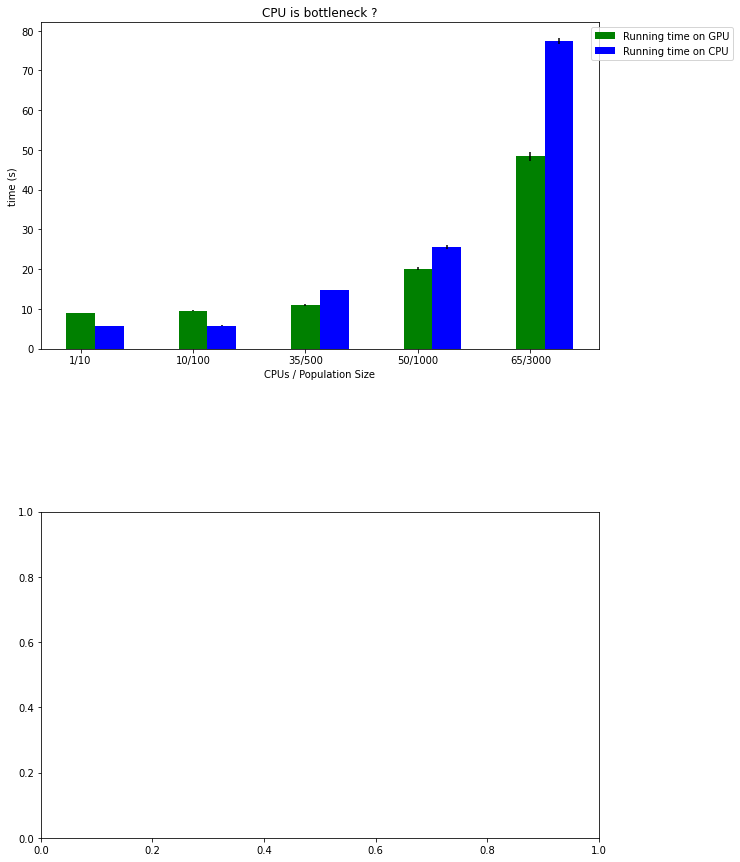

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

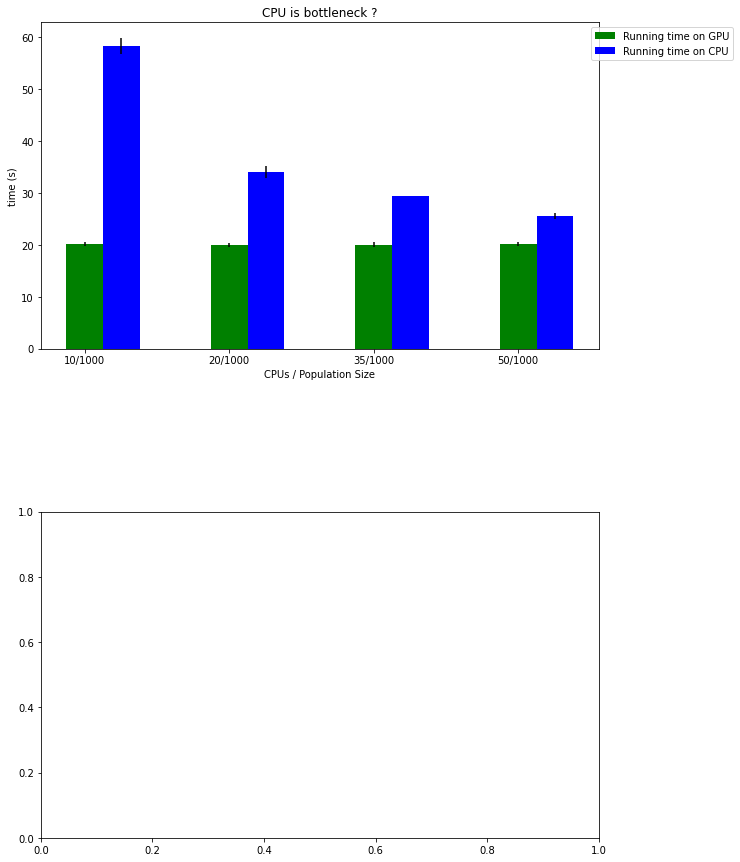

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [52]:

def plot_CPUGPU_bottleneck(cpu_list, offspring_list, nodes=1):
    """
    TODO: consider changing this to be a single plot output
    """
    # INSERT FOR LOOP HERE
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
    plt.subplots_adjust(bottom=None, right=None, top=None, wspace=None, hspace=.5)
    df = pd.DataFrame(columns=['cpus', 'offspring', 'runtime (mean)', 'runtime stddev' ])


    for i in range(len(cpu_list)):
        cpu = cpu_list[i]
        offspring = offspring_list[i]
        f  = "runTimeLogs/{}C{}N_{}O.log".format(cpu,nodes, offspring)
        logRes = processLog(f)
        mean_runtime, std_runtime = np.mean(logRes['runtimes']), np.std(logRes['runtimes'])
        mean_eval, std_eval = np.mean(logRes['evalTimes']), np.std(logRes['evalTimes'])
        mean_neuroGPU, std_neuroGPU =  np.mean(logRes['neuroGPUTimes']), np.std(logRes['neuroGPUTimes'])
        df.loc[i] = [int(cpu),int(offspring),int(mean_runtime), int(std_runtime)]
        # Figure size
        plt.figure(figsize=(10,5))

        # Width of a bar 
        width = 0.17       
        # Plotting
        if i == 0:
            axs[0].bar(i/1.5, mean_neuroGPU , width, yerr=std_neuroGPU, label='Running time on GPU',color="green")
            axs[0].bar(i/1.5 + width, mean_eval, width, yerr=std_eval, label='Running time on CPU', color="blue")
        else:
            axs[0].bar(i/1.5, mean_neuroGPU , width, yerr=std_neuroGPU,color="green")
            axs[0].bar(i/1.5 + width, mean_eval, width, yerr=std_eval, color="blue")
            
    axs[0].legend(bbox_to_anchor=(1.25, 1), loc='upper right', ncol=1)
    axs[0].set_xlabel('CPUs / Population Size')
    axs[0].set_xticks(ticks=[i/1.5 for i in range(len(cpu_list))])
    axs[0].set_xticklabels(labels=["{}/{}".format(cpu,pop) for cpu, pop in zip(cpu_list,offspring_list)])
    axs[0].set_ylabel('time (s)')
    axs[0].set_title('CPU is bottleneck ?')
    fig.savefig("plots/cpu_plot_{}".format(np.array(cpu_list).astype(str)))
    df.to_latex("plots/cpu_runTable_{}".format(np.array(cpu_list).astype(str)))
    
    
    print(df)

    
plot_CPUGPU_bottleneck([1,10,35,50,65],[10,100,500,1000,3000])
plot_CPUGPU_bottleneck([10,20,35,50],[1000,1000,1000,1000,1000])

In [54]:
"""
This will only work for last generation for now but that is ok to just
obtain graph. later will need to change process log logic so that keys
don't get clobbered
"""

procEndDict = logRes['procEndDict']

compStartDict = logRes['compStartDict']
procStartDict = logRes['procStartDict']
startEndPairs = logRes['startEndPairs']
official_start = float(startEndPairs[-1][0])
labels = list(compStartDict.keys())
computing = np.array(list(procEndDict.values())).astype(np.float32) - np.array(list(compStartDict.values())).astype(np.float32)
comm = np.array(list(procStartDict.values())).astype(np.float32) - computing
comm = np.repeat(official_start,len(comm)) - np.array(list(compStartDict.values())).astype(np.float32)
print(comm)
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, computing, width, label='Communication')
ax.bar(labels, comm, width, bottom=computing,
       label='Computation')

ax.set_ylabel('Time(s)')
ax.set_title('Computation vs. Commmunication in Processes')
ax.legend()

plt.show()


<ipython-input-54-ae2eaf3c6759>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  computing = np.array(list(procEndDict.values())).astype(np.float32) - np.array(list(compStartDict.values())).astype(np.float32)


ValueError: setting an array element with a sequence.

16
max height exc.
max height exceeded


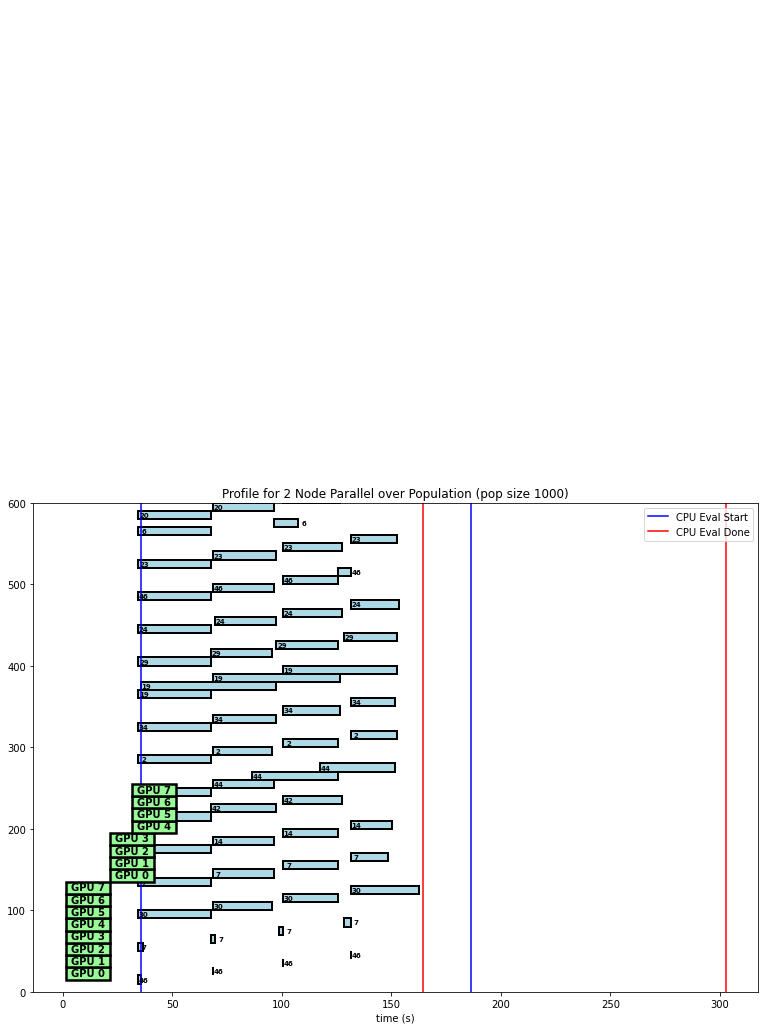

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def makeCustomProfile(nCpus,nodes,popSize, show=True):
    f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpus,nodes, popSize)
    #f  = "runTimeLogs/runTime.log"
    logRes = processLog(f)
    absStart = float(logRes['absStart'])
    start_data = np.array([float(start) for start in logRes["neuroGPUStartTimes"]]) 
    end_data = np.array(logRes["neuroGPUEndTimes"]).astype(float)
    print(len(start_data))
    times = logRes["neuroGPUTimes"]
    # bugged timer
    end_data = np.mean(times) + start_data
    procEndDict = logRes['procEndDict']
    sfsMap = logRes['procToSf']
    sfsMapMap = {}
    counter = 0
    for val in set(list(sfsMap.values())):
        sfsMapMap[val] = counter
        counter +=1

    nGpus = 8# THIS SHOULD BE IN LOG RES logRes['nGpus']
    compStartDict = logRes['compStartDict']
    procStartDict = logRes['procStartDict']
    
    startEndPairs = logRes['startEndPairs']
    #print(absStart)

    #print(startEndPairs)

    startEndPairs = [(float(pair0) - float(absStart), float(pair1) - float(absStart)) for pair0, pair1 in startEndPairs]
    #print(procStartDict)
    #print(startEndPairs)
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(13,9))
    
    # YLIM XLIM
    plt.ylim(0,600)
    #plt.xlim(0,120)
    
    
    
    x_anchors= []
    x_ends = []

    def calc_y_anchor(x_anchor,width,x_anchors,x_ends):
        curr_ht = 0
        for x_anc, x_end in zip(x_anchors,x_ends):
            if x_anchor > x_anc and x_anchor < x_end:
                curr_ht += 10
            elif x_anc > x_anchor and x_anc < x_anchor+width:
                curr_ht += 10
        return curr_ht

    cur_start = 0
    y_base = 0
    firstGo = True
    for start, end in startEndPairs:
        if firstGo:
            firstGo = False
            plt.axvline(x=start,color="blue", label="CPU Eval Start")
            plt.axvline(x=end,color="red", label="CPU Eval Done")
        else:
            plt.axvline(x=start,color="blue")
            plt.axvline(x=end,color="red")



    idx = 1
    labels = list(compStartDict.keys())
    box_ht = 10
    for procStart,procEnd,proc in \
    zip(list(procStartDict.values()),list(procEndDict.values()), list(procEndDict.keys()) ):
        for pStart,pEnd in zip(procStart,procEnd):
            x_anchor = float(pStart)  - float(absStart)#float(procStart) - float(absStart)
            y_anchor = y_base + 10
            if x_anchor > float(startEndPairs[cur_start][1]) and cur_start < len(startEndPairs) - 1 :
                cur_start += 1
                y_base = 0
            else:
                y_base += 10
            
            if y_base > 1200: # MAX HEIGHT EXCEEDED
                print('max height exc.')
                break
            width =(float(pEnd) - float(absStart)) - (float(pStart) - float(absStart)) #(float(procEnd) - float(absStart)) - (float(procStart) - float(absStart))
            #y_anchor = calc_y_anchor(x_anchor,width,x_anchors,x_ends)
            x_anchors.append(float(x_anchor)), x_ends.append(width)
            rect = patches.Rectangle((x_anchor, y_anchor), width, box_ht, \
                                     linewidth=2, edgecolor='black', facecolor='lightblue', fill=True, zorder=0)
            curr_sf = sfsMapMap[sfsMap[proc]]
            ax.annotate(curr_sf, (x_anchor + 2.5, y_anchor + 5), color='black', weight='bold', \
                        fontsize=7, ha='center', va='center', zorder=4)
            # Add the patch to the Axes
            ax.add_patch(rect)
            idx += 1
        if y_base > 1200:
            print("max height exceeded")
            break


    # Create a Rectangle patches
    box_ht = 15 # constant box height
    cur_start = 0
    y_base = 0
    for start,end,idx in zip(start_data,end_data, np.arange(len(end_data))):
        x_anchor = start-absStart
        if x_anchor > float(startEndPairs[cur_start][1]):
            cur_start += 2
            y_base = 0
        else:
            y_base += 15
        y_anchor = y_base
        width =  end - start
        x_anchors.append(float(x_anchor)), x_ends.append(width)
        rect = patches.Rectangle((x_anchor, y_anchor), width, box_ht, \
                                 linewidth=2.5, edgecolor='black', facecolor='palegreen', fill=True, zorder=10)
        ax.annotate("GPU {}".format(idx %  nGpus), (x_anchor + 10, y_anchor + 8), color='black', weight='bold', 
                    fontsize=10, ha='center', va='center', zorder=20)

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.title("Profile for {} Node Parallel over Population (pop size {})".format(nodes, popSize))
    #plt.title("Custom Profile for {} CPUs, {} Pop Size and {} Nodes".format(nCpus,nodes,popSize))
    plt.legend()
    plt.xlabel("time (s)")
    #plt.show()
    plt.savefig("plots/my_profille_{}C{}N{}".format(nCpus,nodes,popSize))
    
makeCustomProfile(40,2,1000)

In [56]:

def make_legend(top):
    fig, ax = plt.subplots(figsize=(8, 5))
    y = 9
    level = 0
    start = 9
    for name, val in top.items():
        ax.text(start, y - level, str(val) + "--> " + name, fontsize=20)
        level += 1

    ax.axis([0, 10, 0, 10])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    plt.show()
f  = "runTimeLogs/runTime.log"
# f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
logRes = processLog(f)
sfsMap = logRes['procToSf']
sfsMapMap = {}
counter = 0
for val in set(list(sfsMap.values())):
    sfsMapMap[val] = counter
    counter +=1
#make_legend(sfsMapMap)

FileNotFoundError: [Errno 2] No such file or directory: 'runTimeLogs/runTime.log'

In [57]:
def roofline1(nCpus,nodes,popSize, tickPos, ax, labels=False, show=True):
    #f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpus,nodes, popSize)
    f  = "runTimeLogs/runTime.log"
    logRes = processLog(f)
    absStart = float(logRes['absStart'])
    start_data = np.array([float(start) for start in logRes["neuroGPUStartTimes"]]) 
    end_data = np.array(logRes["neuroGPUEndTimes"]).astype(float)
    times = logRes["neuroGPUTimes"]
    end_data = np.mean(times) + start_data
    procEndDict = logRes['procEndDict']
    sfsMap = logRes['procToSf']


    nGpus = 8# THIS SHOULD BE IN LOG RES logRes['nGpus']
    compStartDict = logRes['compStartDict']
    procStartDict = logRes['procStartDict']
    startEndPairs = logRes['startEndPairs']
    startEndPairs = [(float(pair0) - float(absStart), float(pair1) - float(absStart)) for pair0, pair1 in startEndPairs]
    # Create figure and axes

    comp_total = 0
    i_o_total = np.sum(logRes['ioTimes'])
    comm_total = 0 
    for start, end in startEndPairs:
        for procStart, procEnd, compStart in \
        zip(list(procStartDict.values()), list(procEndDict.values()), list(compStartDict.values())):
            for idx,(pStart,pEnd,cStart) in enumerate(zip(procStart,procEnd, compStart)): 
                if float(pStart) - float(absStart) > float(start)\
                and float(pEnd) - float(absStart) <= float(end) and idx == 0: # add communication between starting map
                    comm_total += float(pStart) - float(absStart) - float(start ) 
                    comp_total += float(pEnd) - float(cStart) 
                else: # add communication between it's previous starting score function and it's run
                    comm_total += float(procStart[idx]) - float(procStart[idx-1]) 
                    comp_total += float(pEnd) - float(cStart) 
    width = 1 
    if labels:
        plt.bar(tickPos, comm_total, width, label='comm', color="grey", edgecolor='black',linewidth=1.5)
        plt.bar(tickPos, comp_total, width, bottom=comm_total,
               label='comp', color="black")
        plt.bar(tickPos, i_o_total, width, bottom=comm_total+comp_total,
               label='io', color='green')
    else:
        plt.bar(tickPos, comm_total, width, color="grey", edgecolor='black',linewidth=1.5)
        plt.bar(tickPos, comp_total, width, bottom=comm_total, color="black")
        plt.bar(tickPos, i_o_total, width, bottom=comm_total+comp_total, color='green')
    #plt.bar(["comm", "comp", "io"],[comm_total,comp_total,i_o_total])
    print(comm_total / 1000,comp_total / 1000)
    print(logRes['runtimes'] )
    return "{}C{}N_{}O".format(nCpus,nodes, popSize)
    
    
plt.figure()
exps = [[65,1,1000], [35,1,1000], [5,1,100]]
labels = []
for idx, exp in enumerate(exps):
    if idx == 0:
        labels.append(roofline1(exp[0], exp[1], exp[2],idx,ax,labels=True))
    else:
        labels.append(roofline1(exp[0], exp[1], exp[2],idx,ax))
plt.legend()
plt.xticks(ticks=np.arange(len(exps)), labels=labels)
plt.legend()
plt.title("Title goes here")
plt.ylabel("time (ms)")
#plt.savefig("plots/my_profille_{}C{}N{}".format(nCpus,nodes,popSize))
    

NameError: name 'ax' is not defined

<Figure size 432x288 with 0 Axes>

(0.3854372851222534, 0.36491254700642584)

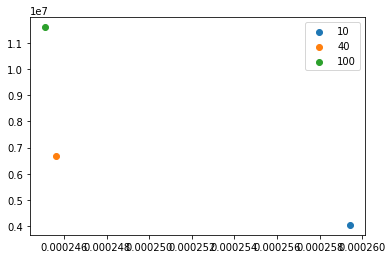

In [58]:
def read_mixtape(path):
    with open(path,"r") as f:
        lines = [line for line in f.readlines()]
    for line in lines:
        if "Total FLOPs" in line:
            numbers = re.findall(r'\d+', line)
            total_flops = int(numbers[0])
        if "Total Bytes" in line:
            numbers = re.findall(r'\d+', line)
            total_bytes = int(numbers[0])
    return total_flops, total_bytes

        
total_flops,total_bytes = read_mixtape("mixtapes/test.txt")
AI = total_flops / total_bytes
runtime = 109
gflops = total_flops / runtime
plt.scatter(AI, gflops, label="10")


total_flops,total_bytes = read_mixtape("mixtapes/test2.txt")
AI = total_flops / total_bytes
runtime = 171.3363344669342
gflops = total_flops / runtime
plt.scatter(AI,gflops, label="40")


total_flops,total_bytes = read_mixtape("mixtapes/test3.txt")
AI = total_flops / total_bytes
runtime = 308.3363344669342
gflops = total_flops / runtime
plt.scatter(AI,gflops, label="100")


plt.legend()


440139874 / 1141923449 , 1696623459585 / 4649397433723

In [72]:
def processLog(f):
    with open(f, "r") as file:
        startEndPairs = []
        runtimes = []
        sfs = []
        neuroGPUStartTimes = []
        neuroGPUEndTimes = []
        procToSf = {}
        procStartDict = {}
        procEndDict = {}
        compStartDict = {}
        io_times = []
        file_lines =file.readlines()
        readingEnds = False
        readingStarts = False
        for line in file_lines:
            if "Date:" in line:
                print(line)
            if "absolute start" in line:
                numbers = re.findall(r'\d+', line)
                abs_start = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ][0]
            if "nCpus" in line:
                nCpus = int(re.match('.*?([0-9]+)$', line).group(1))
                #assert nCpus  == cpu, "expected {} but got {} cpus in log".format(cpu,nCpus)
            if "took:" in line:
                runtime = float(re.findall(r"[-+]?\d*\.\d+|\d+",line)[1])
                #print(runtime)
                runtimes.append(runtime)
            if "launched PIDS" in line:
                start = re.findall(r'\d+', line)[0] # second half is in miliseconds, don't need that precision
                
            if "finished PIDS" in line:
                end = re.findall(r'\d+', line)[0] 
                startEndPairs.append((start,end))
            if "process"  in line and "started" in line:
                stSplit = line.split(" ")
                sf = [stSplit[i] for i in range(2,len(stSplit)-2) if stSplit[i-1] == "is" and  stSplit[i+1] == "and"][0]
                sfs.append(sf)
                line = re.sub(r'(?<=is)(.*)(?=and)', "", line)
                numbers = re.findall(r'\d+', line)

                procToSf[numbers[0]] = sf
                if numbers[0] in procStartDict.keys():
                    procStartDict[numbers[0]].append(numbers[1])
                else:
                    procStartDict[numbers[0]] = [numbers[1]]
            if "returning" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in procEndDict.keys():
                    procEndDict[numbers[0]].append(numbers[1])
                else:
                    procEndDict[numbers[0]] = [numbers[1]]
            if "computing" in line:
                numbers = re.findall(r'\d+', line)
                if numbers[0] in compStartDict.keys():
                    compStartDict[numbers[0]].append(numbers[1])
                else:
                    compStartDict[numbers[0]] = [numbers[1]]
            if "evaluation:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                evalTimes = np.array(list(numbers), dtype=np.float32)
                avgEval = np.mean(evalTimes)
            if "neuroGPU" in line and "starts" not in line and "ends" not in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join(x) for x in zip(numbers[0::2], numbers[1::2]) ]
                neuroGPUTimes = np.array(list(numbers),dtype=np.float32)
                avgNGPU = np.mean(neuroGPUTimes)
            if ("neuroGPU" in line and "starts" in line and "ends" not in line) or readingEnds:
                readingEnds = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUStartTimes += numbers
                if "]" in line:
                    readingEnds = False
            if ("neuroGPU" in line and "starts" not in line and "ends" in line) or readingStarts:
                readingStarts = True
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                neuroGPUEndTimes += numbers
                if "]" in line:
                    readingStarts = False
            if "IO:" in line:
                numbers = re.findall(r'\d+', line)
                numbers = [ '.'.join([x1,x2]) + "e+" + str(x3) for x1,x2,x3 in zip(numbers[0::3], numbers[1::3], numbers[2::3]) ]
                io_times.append(numbers)
            
            
    res = {"procStartDict": procStartDict,"procEndDict": procEndDict,\
           "startEndPairs": startEndPairs,"runtimes": runtimes,\
           "compStartDict": compStartDict,"sfs": sfs,\
           "evalTimes": evalTimes,"neuroGPUTimes": neuroGPUTimes,\
          "procToSf": procToSf, "absStart": abs_start, \
           "neuroGPUStartTimes": neuroGPUStartTimes, \
           "neuroGPUEndTimes": neuroGPUEndTimes, "ioTimes": io_times}
    return res
f  = "runTimeLogs/{}C{}N_{}O.log".format(80,1, 1000)
logRes = processLog(f)

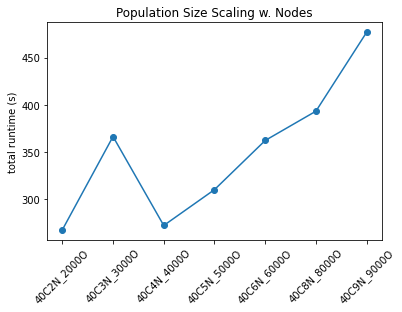

In [75]:
def plotScaling(nCpus,nodes,popSize, show=True):
    #f  = "runTimeLogs/runTime.log"
    runtimes = []
    labels = []
    for idx,(node,pop,nCpu) in enumerate(zip(nodes,pops,nCpus)):
        f  = "runTimeLogs/{}C{}N_{}O.log".format(nCpu,node, 1000)
        logRes = processLog(f)
        runtime = np.mean(logRes['runtimes'])
        runtimes.append(runtime)
        label = "{}C{}N_{}O".format(nCpu,node, pop)
        labels.append(label)
    plt.scatter(np.arange(len(runtimes)), runtimes)
    plt.plot(np.arange(len(runtimes)), runtimes)
    plt.xticks(ticks=np.arange(len(runtimes)), labels=labels, rotation=45)
    plt.ylabel("total runtime (s)")
    
nodes = [2,3,4,5,6,8,9]
pops = [node*1000 for node in nodes]
nCpus = np.repeat(40, len(nodes))
plt.title("Population Size Scaling w. Nodes")
plotScaling(nCpus,nodes,pops)